In [1]:
import pandas as pd
import seaborn as sns
import sqlalchemy as sql
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

import matplotlib.backends.backend_pdf

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [2]:
string_connection = 'mysql+mysqlconnector://{user}:{password}@{server}/{database}'.format(
                    user='root',
                    password='125478',
                    server='127.0.0.1',
                    database='analise_risco')

cnx = sql.create_engine(string_connection)


In [3]:
dados_raw = pd.read_sql('select * from analise_risco.dados_modelo_ml', cnx)

dados_raw.head()

,pessoa_id,pessoa_idade,salario_ano,propriedade_sit,ano_trabalhado,motivo_emprestimo,pontuacao_emprestimos,vl_total,tx_juros,inadimplencia,tx_renda_divida,hst_inadimplencia,hst_primeiro_credito
0,283zsKkk-MN9S,23.000,108000.000,Hipotecada,5.000,Pagamento de débitos,D,10000.000,NaN,1.000,0.090,1.000,2
1,4tD36gcw-IrsA,31.000,35000.000,Hipotecada,2.000,Pagamento de débitos,B,10225.000,9.990,0.000,0.290,0.000,6
2,08iwXXZl-5U5x,22.000,14400.000,Própria,0.000,Pessoal,B,2100.000,11.140,0.000,0.150,0.000,4
3,0PtiPv5h-nd0L,21.000,47580.000,Hipotecada,5.000,Educativo,A,14000.000,6.030,0.000,0.290,0.000,2
4,3QKc0Idh-OAkE,33.000,115000.000,Hipotecada,10.000,Médico,B,25000.000,11.860,0.000,0.220,0.000,8


In [4]:
dados_raw.corr()

,pessoa_idade,salario_ano,ano_trabalhado,vl_total,tx_juros,inadimplencia,tx_renda_divida,hst_inadimplencia,hst_primeiro_credito
pessoa_idade,1.000,0.174,0.164,0.048,0.013,-0.021,-0.041,0.005,0.819
salario_ano,0.174,1.000,0.136,0.258,0.001,-0.139,-0.247,-0.004,0.114
ano_trabalhado,0.164,0.136,1.000,0.107,-0.055,-0.081,-0.054,-0.027,0.138
vl_total,0.048,0.258,0.107,1.000,0.149,0.105,0.574,0.040,0.043
tx_juros,0.013,0.001,-0.055,0.149,1.000,0.336,0.121,0.501,0.017
inadimplencia,-0.021,-0.139,-0.081,0.105,0.336,1.000,0.378,0.177,-0.015
tx_renda_divida,-0.041,-0.247,-0.054,0.574,0.121,0.378,1.000,0.036,-0.032
hst_inadimplencia,0.005,-0.004,-0.027,0.040,0.501,0.177,0.036,1.000,0.004
hst_primeiro_credito,0.819,0.114,0.138,0.043,0.017,-0.015,-0.032,0.004,1.000


Existe uma alta correlação entre tx_renda_divida e vl_total, ja que este numérico é construído através de calculo entre
    vl_total e salario_ano.

Optei por excluir a coluna do modelo com intuito de simplificar o conjunto.

In [5]:
dados = dados_raw.drop(columns=['tx_renda_divida'])

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34485 entries, 0 to 34484
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pessoa_id              34485 non-null  object 
 1   pessoa_idade           34165 non-null  float64
 2   salario_ano            34150 non-null  float64
 3   propriedade_sit        34485 non-null  object 
 4   ano_trabalhado         33231 non-null  float64
 5   motivo_emprestimo      34485 non-null  object 
 6   pontuacao_emprestimos  34485 non-null  object 
 7   vl_total               34154 non-null  float64
 8   tx_juros               30859 non-null  float64
 9   inadimplencia          34142 non-null  float64
 10  hst_inadimplencia      34119 non-null  float64
 11  hst_primeiro_credito   34485 non-null  int64  
dtypes: float64(7), int64(1), object(4)
memory usage: 3.2+ MB


# Tratando as colunas com variaveis categóricas.

   Vamos utilizar o OneHotEncoder para realizar este processo.

In [7]:

colunas_categoricas = ['propriedade_sit',
                       'motivo_emprestimo', 'pontuacao_emprestimos']

one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),
     colunas_categoricas),
    remainder='passthrough')

dados = one_hot_enc.fit_transform(dados)

dados = pd.DataFrame(dados, columns=one_hot_enc.get_feature_names())
dados.head()


c:\Users\PauloVinicius\Documents\GitHub\AluraChallengeDataScience2\ambienteAluraChallengeDados\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,onehotencoder__x0_-,onehotencoder__x0_Alugada,onehotencoder__x0_Hipotecada,onehotencoder__x0_Outros,onehotencoder__x0_Própria,onehotencoder__x1_-,onehotencoder__x1_Educativo,onehotencoder__x1_Empreendimento,onehotencoder__x1_Melhora do lar,onehotencoder__x1_Médico,...,onehotencoder__x2_G,pessoa_id,pessoa_idade,salario_ano,ano_trabalhado,vl_total,tx_juros,inadimplencia,hst_inadimplencia,hst_primeiro_credito
0,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,283zsKkk-MN9S,23.000,108000.000,5.000,10000.000,NaN,1.000,1.000,2
1,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,4tD36gcw-IrsA,31.000,35000.000,2.000,10225.000,9.990,0.000,0.000,6
2,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,...,0.000,08iwXXZl-5U5x,22.000,14400.000,0.000,2100.000,11.140,0.000,0.000,4
3,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,0.000,0PtiPv5h-nd0L,21.000,47580.000,5.000,14000.000,6.030,0.000,0.000,2
4,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,0.000,3QKc0Idh-OAkE,33.000,115000.000,10.000,25000.000,11.860,0.000,0.000,8


# Trabalhando com os Nulos.

  - Criar um Dataset sem nulos.
  - Criar um Dataset com os nulos tratados.


Dataset sem nulos:

In [8]:
df_dados_semnulos = dados.dropna()


Nulos Tratados

A idea é obter a mediana da variavel alvo atraves de agrupamento de outras variveis a qual não se possui valores nulos nas colunas.

In [9]:

lista_groupby = ['pessoa_idade', 'salario_ano',
                 'ano_trabalhado', 'tx_juros', 'hst_inadimplencia']

# Nas colunas que constam nesta lista, analisei que poderíamos conseguir estimar o dado conforme a média dos dados agrupados por algumas categorias.
for i in lista_groupby:
    dados[i].fillna(dados_raw.groupby(['propriedade_sit', 'motivo_emprestimo'])[i].transform('median'), inplace=True)

# vl_total 331 nulos - Optei por remover esta variavel que é importante para o modelo.
dados.dropna(axis=0,subset=['vl_total'], inplace=True)

# Inadimplência 343 nulos - Vou separar os dados nulos desta coluna para um dataset de predição.
predicao = dados.copy(deep=True)
mask = pd.isnull(dados['inadimplencia'])
predicao = predicao[mask]

# Removendo os dados nulos da coluna inadimplência do dataset que vai para o modelo.
dados.dropna(axis=0,subset=['inadimplencia'], inplace=True)

In [10]:
predicao.reset_index(drop=True, inplace=True)
predicao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   onehotencoder__x0_-                     307 non-null    object 
 1   onehotencoder__x0_Alugada               307 non-null    object 
 2   onehotencoder__x0_Hipotecada            307 non-null    object 
 3   onehotencoder__x0_Outros                307 non-null    object 
 4   onehotencoder__x0_Própria               307 non-null    object 
 5   onehotencoder__x1_-                     307 non-null    object 
 6   onehotencoder__x1_Educativo             307 non-null    object 
 7   onehotencoder__x1_Empreendimento        307 non-null    object 
 8   onehotencoder__x1_Melhora do lar        307 non-null    object 
 9   onehotencoder__x1_Médico                307 non-null    object 
 10  onehotencoder__x1_Pagamento de débitos  307 non-null    object

# Tratamento de Variaveis Numericas

In [11]:
colunas_float = dados.select_dtypes(include=['float64']).columns

for i in colunas_float:
    dados[i] = dados[i].astype('int64')


In [21]:

colunas_numericas = ["pessoa_idade",
"salario_ano",
"ano_trabalhado",
"vl_total",
"tx_juros",
"hst_primeiro_credito"]

dados[colunas_numericas].describe()


,pessoa_idade,salario_ano,ano_trabalhado,tx_juros
count,33842.000,33842.000,33842.000,33842.000
mean,27.701,65810.052,4.765,10.443
std,6.183,52148.092,4.076,3.103
min,20.000,4000.000,0.000,5.000
25%,23.000,39000.000,2.000,8.000
50%,26.000,55000.000,4.000,10.000
75%,30.000,79000.000,7.000,13.000
max,94.000,2039784.000,123.000,23.000


# Variaveis Numéricas.

  Alguns gráficos utilizados para analisar as variaveis numéricas.


In [17]:
# for i in colunas_numericas:
#     plt.figure()
#     sns.boxplot(x=dados[i])
    


# Idade

<AxesSubplot:xlabel='pessoa_idade'>

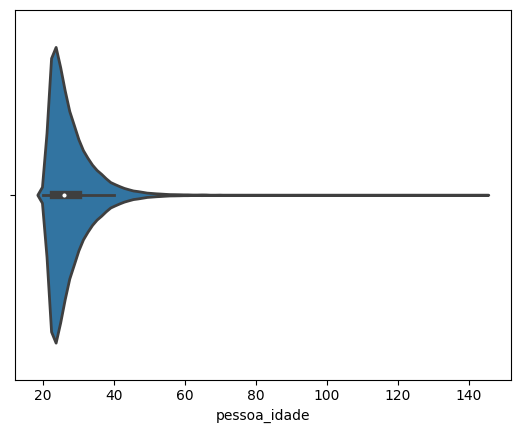

In [13]:
sns.violinplot(x=dados['pessoa_idade'], data=dados, linewidth=2)

<AxesSubplot:xlabel='pessoa_idade', ylabel='count'>

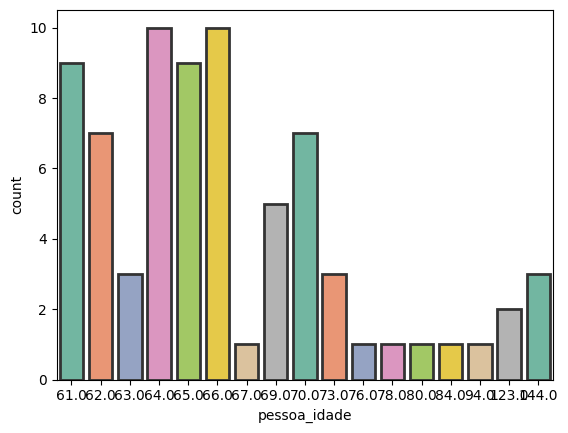

In [14]:
out = dados['pessoa_idade'].where(dados['pessoa_idade'] > 60)
sns.countplot(x=out, data=dados, linewidth=2, palette="Set2", edgecolor=".2")

In [22]:
#Apagar 2 pessoas acima de 100 anos
dados.drop(dados[dados["pessoa_idade"] > 86].index, inplace=True)

# Percebe-se que a idade se concentra entre 20 e 40 anos
# Teste sobre criar uma coluna de faixas etárias com intervalo de 5 anos.

faixa_etaria = [15, 20,25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
faixa_etaria_labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

dados['faixa_idade'] = pd.cut(
    x=dados['pessoa_idade'], bins=faixa_etaria, labels=faixa_etaria_labels)


predicao['faixa_idade'] = pd.cut(
    x=predicao['pessoa_idade'], bins=faixa_etaria, labels=faixa_etaria_labels)



# Salario Ano

In [23]:
dados['Faixa_Salarial'] = pd.qcut(dados['salario_ano'],  q=10, labels=False)

predicao['Faixa_Salarial'] = pd.qcut(predicao['salario_ano'],  q=10, labels=False)


# Ano Trabalhado

<AxesSubplot:xlabel='ano_trabalhado', ylabel='count'>

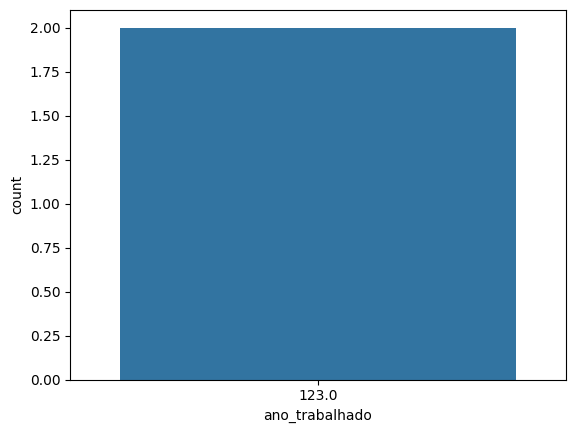

In [28]:
out = dados['ano_trabalhado'].where(dados['ano_trabalhado'] > 50)
sns.countplot(x=out)


In [29]:
dados.drop(
    dados[dados["ano_trabalhado"] > 100].index, inplace=True)


<AxesSubplot:xlabel='ano_trabalhado', ylabel='count'>

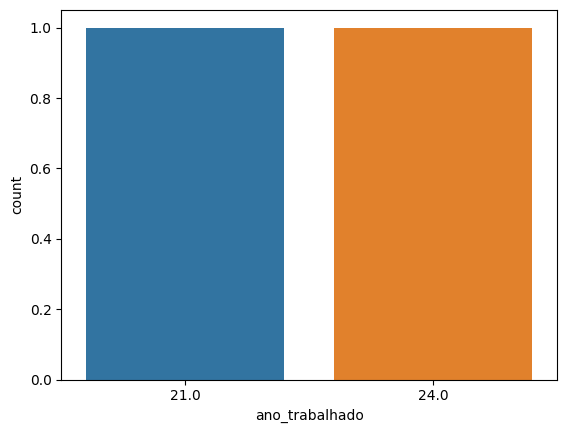

In [30]:
out = predicao['ano_trabalhado'].where(predicao['ano_trabalhado'] > 20)
sns.countplot(x=out)


# Valor Total

<AxesSubplot:xlabel='vl_total', ylabel='count'>

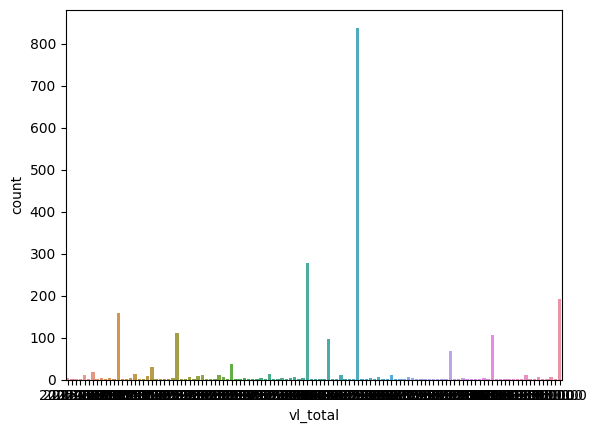

In [31]:
out = dados['vl_total'].where(dados['vl_total'] > 20000)
sns.countplot(x=out)


In [32]:
dados['Faixa_Emprestimo'] = pd.cut(x= dados['vl_total'], bins=35, labels=False)

# predicao['Faixa_Emprestimo'] = pd.cut(x=predicao['vl_total'], bins=35, labels=False)


<AxesSubplot:xlabel='Faixa_Emprestimo', ylabel='count'>

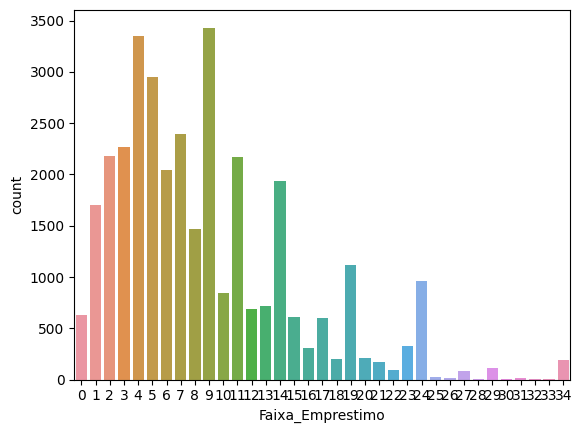

In [33]:
sns.countplot(x=dados['Faixa_Emprestimo'])

# Primeiro Credito

<AxesSubplot:xlabel='faixa_idade', ylabel='hst_primeiro_credito'>

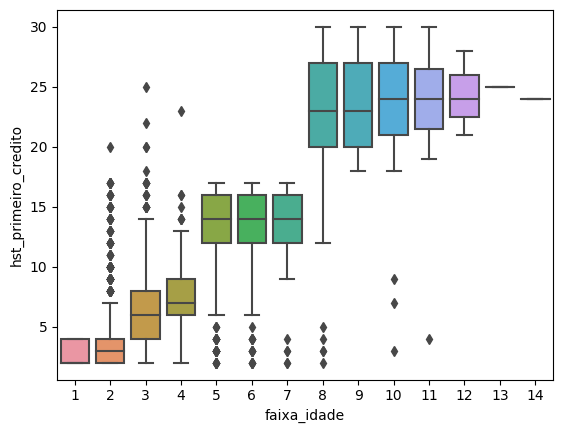

In [38]:

sns.boxplot(x=dados['faixa_idade'],
            y=dados['hst_primeiro_credito'])

# print(dados['pessoa_idade'].where(dados['faixa_idade'] == 2).unique())


In [35]:
dados.drop(dados[(dados["faixa_idade"] == 2) &(dados['hst_primeiro_credito'] > 20)].index, inplace=True)

In [36]:
dados.drop(dados[(dados["faixa_idade"] == 3) &(dados['hst_primeiro_credito'] > 25)].index, inplace=True)

# Finalizando
 - Exportando os datasets para a pasta Data, onde será lido pelo programa de treino e predição.
 

In [37]:
dados.describe()

dados.to_csv('Data/Dados.csv', index=False)

df_dados_semnulos.to_csv('Data/Dados_Sem_Nulos.csv', index=False)

# predicao necessita de tratamento das variaveis numericas.
predicao.to_csv('Data/Predicao.csv', index=False)